In [2]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch import nn
import torchvision

# set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Data Preparation

In [22]:
# read datafile (h5)
f = h5py.File("Galaxy10_DECals_2.h5")
images = f.get("images")
labels = f.get("ans")
img_in = np.array(images)
lab_in = np.array(labels)
labs = lab_in

# write data to tensors
imgs = torch.from_numpy(img_in)
labs = torch.from_numpy(labs)
imgs = [x.permute(2, 0, 1) for x in imgs]

# data augmentation based on model input (224 default, 299 for inception)
MOD_INPUT_SIZE = 299
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(MOD_INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
imgs = torch.stack([data_transform(imgs[i]) for i in range(len(imgs))])

# preparing data as (img, label) tuples
dataset = [(i, l) for i, l in zip(imgs, labs)]

# separating training and test/validation data
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=10)

# wrapping dataloader for training
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

/home/bhora.y/.conda/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


## Model Training

### Training and Test Loops

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    loss_l = []
    
    for batch, (X, y) in enumerate(dataloader):
        # send data to device
        X, y = X.to(device), y.to(device)
        
        # compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record metrics
        loss_l.append(loss.item())
        
        if batch % 32 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return loss_l
            
def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
    
    # calculate average test loss
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

In [28]:
# define parameters
model_name = 'inception'
learning_rate = 1e-3
batch_size = 64
mm = 0.9
sch_step = 5
epochs = 17

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# initialize model
model_conv = torchvision.models.inception_v3(pretrained=True)
model_conv.aux_logits=False # only for inceptionv3

# reconfigure final layer of model for transfer learning to dataset
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

# num_ftrs = model_conv.classifier[1].in_features
# model_conv.classifier = nn.Linear(num_ftrs, 10)

# send model to device
model_conv = model_conv.to(device)

# initialize the loss function
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

# set optimizer with momentum and scheduler to decay learning rate over epochs
optimizer = torch.optim.SGD(model_conv.parameters(), lr=learning_rate, momentum=mm)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=sch_step, gamma=0.1)

# data collection
epoch_l = list(range(epochs))
data_seen = range(len(train_dataloader.dataset)*epochs)
test_l = []
correct_l = []
lost_tot = []
max_acc = 0

# training
for t in epoch_l:
    print(f"Epoch {t+1}\n-------------------------------")
    lost_l = train_loop(train_dataloader, model_conv, loss_fn, optimizer, device)
    
    # step scheduler
    exp_lr_scheduler.step()
    
    # add data
    lost_tot.extend(lost_l)
    test_loss, correct = test_loop(test_dataloader, model_conv, loss_fn, device)
    
    if t == 0:
        max_acc = correct
    
    # saving best model
    if correct > max_acc:
        max_acc = correct
        torch.save(model_conv, f'models/{model_name}.pth')
        torch.save(model_conv.state_dict(), f'models/{model_name}_weights.pth')
        print(f'Saved Model with Accuracy {correct:>0.3f}')
    
    test_l.append(test_loss)
    correct_l.append(correct)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.289251  [   64/15962]
loss: 2.167606  [ 2112/15962]
loss: 1.936462  [ 4160/15962]
loss: 1.894924  [ 6208/15962]
loss: 1.449507  [ 8256/15962]
loss: 1.300205  [10304/15962]
loss: 1.256373  [12352/15962]
loss: 1.218195  [14400/15962]
Test Error: 
 Accuracy: 61.6%, Avg loss: 1.114982 

Epoch 2
-------------------------------
loss: 0.889085  [   64/15962]
loss: 1.042480  [ 2112/15962]
loss: 0.905407  [ 4160/15962]
loss: 0.791424  [ 6208/15962]
loss: 0.790620  [ 8256/15962]
loss: 0.971709  [10304/15962]
loss: 1.012235  [12352/15962]
loss: 0.850480  [14400/15962]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.879910 

Saved Model with Accuracy 0.701
Epoch 3
-------------------------------
loss: 0.685314  [   64/15962]
loss: 0.677105  [ 2112/15962]
loss: 0.566884  [ 4160/15962]
loss: 0.830855  [ 6208/15962]
loss: 0.696752  [ 8256/15962]
loss: 0.573488  [10304/15962]
loss: 0.792099  [12352/15962]
loss: 0.973929  [14400/15962]
Test Error: 
 Accuracy: 

## Model Evaluation

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
model_name

'inception'

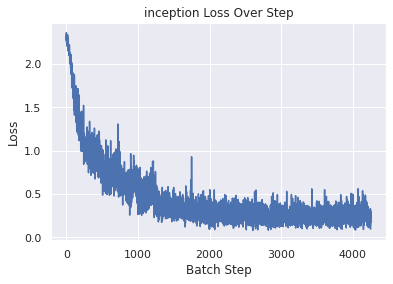

In [30]:
sns.set()

# loss over step
step = list(range(len(lost_tot)))
plt.plot(step, lost_tot)
plt.title(f'{model_name} Loss Over Step')
plt.ylabel('Loss')
plt.xlabel('Batch Step')
plt.savefig(f'plots/{model_name}_training_loss.png', bbox_inches='tight', dpi=300)

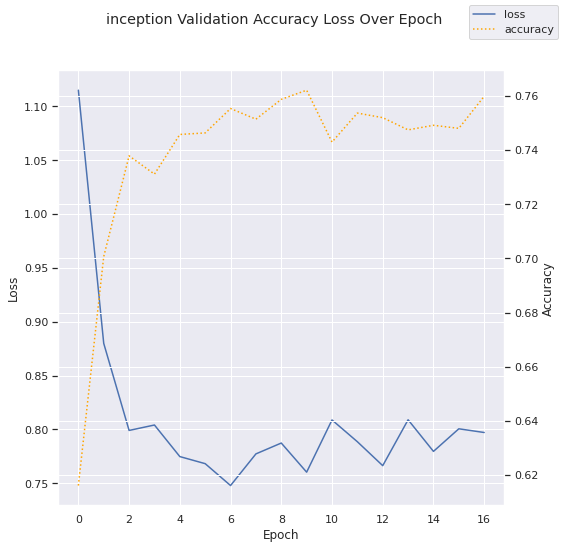

In [31]:
# loss over step
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax1.plot(epoch_l, test_l, label='loss')
ax2.plot(epoch_l, correct_l, color='orange', linestyle='dotted', label='accuracy')
fig.legend()

# labels
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
fig.suptitle(f'{model_name} Validation Accuracy Loss Over Epoch')
fig.savefig(f'plots/{model_name}_test_stat.png', bbox_inches='tight', dpi=400)

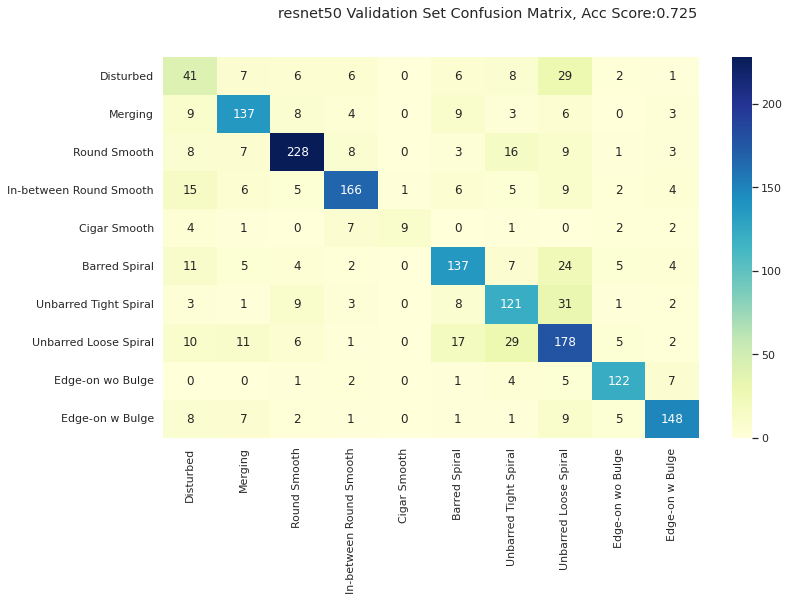

In [39]:
#model_name = 'resnet50'
model = torch.load(f'models/{model_name}.pth')

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Smooth',
        'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on wo Bulge', 'Edge-on w Bulge')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
conf_plot = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt='g')
fig = conf_plot.get_figure()
acc_score = accuracy_score(y_true, y_pred)
fig.suptitle(f'{model_name} Validation Set Confusion Matrix, Acc Score:{acc_score:>0.3f}')
fig.savefig(f'plots/{model_name}_conf_mat.png', bbox_inches='tight', dpi=500)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

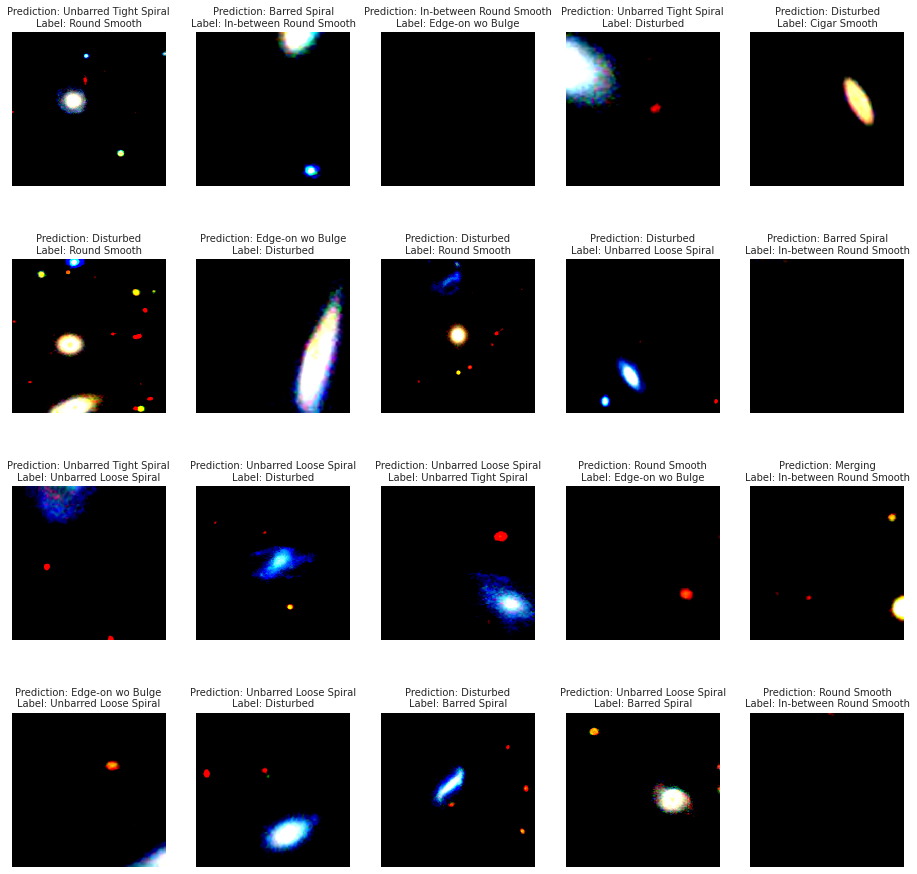

In [41]:
incorrect_imgs = torch.Tensor().to(device)
incorrect_preds = torch.IntTensor().to(device)
incorrect_labels = torch.IntTensor().to(device)

with torch.no_grad():
    # Test set iterator
    it = iter(test_dataloader)
    # Loop over the test set batches until incorrect_imgs.size(0) >= 20
    while incorrect_imgs.size(0) < 20:
        images, labels = next(it)
        images, labels = images.to(device), labels.to(device)

        # ------------------
        # Write your implementation here.

        output = model.forward(images)
        pred = torch.argmax(output, axis=1)

        # Compare prediction and true labels and append the incorrect predictions
        # using `torch.cat`. 
        mask = pred != labels
        incorrect_imgs = images[mask]
        incorrect_preds = pred[mask]
        incorrect_labels = labels[mask]
incorrect_imgs = incorrect_imgs.permute(0, 3, 2, 1)

fig = plt.figure(figsize=(16, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(incorrect_imgs[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {classes[incorrect_preds[i].item()]}\nLabel: {classes[incorrect_labels[i].item()]}', fontsize=10)
    plt.axis('off')
    plt.savefig(f"plots/{model_name}_wrong_pred.png", dpi=400)